In [1]:
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import hnn_core
from hnn_core import calcium_model, simulate_dipole, read_params, pick_connection
from hnn_core.network_models import add_erp_drives_to_jones_model
from hnn_core.network_builder import NetworkBuilder
from hnn_core.cell import _get_gaussian_connection
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import utils
import multiprocessing
import dill
device = torch.device("cuda:0")
num_cores = multiprocessing.cpu_count()
torch.backends.cudnn.enabled = True

In [2]:

def add_noise(net, rate=50, weight=0.01, rng_seed=0):
    # Initialize random number generator for integers
    rng = np.random.default_rng(rng_seed)
    seed_array = rng.integers(0, 1000000, size=1000)

    # Add Poisson drives
    weights_ampa_d1 = {'L2_pyramidal': weight, 'L5_pyramidal': weight,
                       'L2_basket': weight}
    rates_d1 = {'L2_pyramidal': rate, 'L5_pyramidal': rate, 'L2_basket': rate}

    net.add_poisson_drive(
        name='distal', tstart=0, tstop=None, rate_constant=rates_d1, location='distal', n_drive_cells='n_cells',
        cell_specific=True, weights_ampa=weights_ampa_d1, weights_nmda=None, space_constant=1e50,
        synaptic_delays=0.0, probability=0.5, event_seed=seed_array[0], conn_seed=seed_array[1])

    weights_ampa_p1 = {'L2_pyramidal': weight, 'L5_pyramidal': weight,
                       'L2_basket': weight, 'L5_basket': weight}
    rates_p1 = {'L2_pyramidal': rate, 'L5_pyramidal': rate, 'L2_basket': rate, 'L5_basket': rate}

    net.add_poisson_drive(
        name='proximal', tstart=0, tstop=None, rate_constant=rates_p1, location='proximal', n_drive_cells='n_cells',
        cell_specific=True, weights_ampa=weights_ampa_p1, weights_nmda=None, space_constant=1e50,
        synaptic_delays=0.0, probability=0.5, event_seed=seed_array[2], conn_seed=seed_array[3])

In [3]:
rng_seed = 0
hnn_core_root = op.dirname(hnn_core.__file__)
params_fname = op.join(hnn_core_root, 'param', 'default.json')
params = read_params(params_fname)
# params.update({'N_pyr_x': 3, 'N_pyr_y': 3})
net_train = calcium_model(params)
net_validation = net_train.copy()
add_noise(net_train, rng_seed=rng_seed)
add_noise(net_validation, rng_seed=rng_seed+1)


dt = 0.5
dpl_train = simulate_dipole(net_train, dt=dt, tstop=4_000, record_vsec='all', record_isec='all')
dpl_validation = simulate_dipole(net_validation, dt=dt, tstop=2000, record_vsec='all', record_isec='all')

Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Loading custom mechanism files from /home/nick/anaconda3/lib/python3.9/site-packages/hnn_core/mod/x86_64/libnrnmech.so
Building the NEURON model
[Done]
Trial 1: 0.5 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...
Trial 1: 50.0 ms...
Trial 1: 60.0 ms...
Trial 1: 70.0 ms...
Trial 1: 80.0 ms...
Trial 1: 90.0 ms...
Trial 1: 100.0 ms...
Trial 1: 110.0 ms...
Trial 1: 120.0 ms...
Trial 1: 130.0 ms...
Trial 1: 140.0 ms...
Trial 1: 150.0 ms...
Trial 1: 160.0 ms...
Trial 1: 170.0 ms...
Trial 1: 180.0 ms...
Trial 1: 190.0 ms...
Trial 1: 200.0 ms...
Trial 1: 210.0 ms...
Trial 1: 220.0 ms...
Trial 1: 230.0 ms...
Trial 1: 240.0 ms...
Trial 1: 250.0 ms...
Trial 1: 260.0 ms...
Trial 1: 270.0 ms...
Trial 1: 280.0 ms...
Trial 1: 290.0 ms...
Trial 1: 300.0 ms...
Trial 1: 310.0 ms...
Trial 1: 320.0 ms...
Trial 1: 330.0 ms...
Trial 1: 340.0 ms...
Trial 1: 350.0 ms...
Trial 1: 360.0 ms...
Trial 1

In [4]:
# with open('net_train.pkl', 'wb') as f:
#     dill.dump(net_train, f)

# with open('net_validation.pkl', 'wb') as f:
#     dill.dump(net_train, f)

In [5]:
dataset_cell_type = 'L5_pyramidal'
window_size = 500
data_step_size = 500
training_set = utils.CellType_Dataset_Fast(net_train, cell_type=dataset_cell_type, window_size=window_size,
                                           data_step_size=data_step_size, device='cpu')
validation_set = utils.CellType_Dataset_Fast(net_validation, cell_type=dataset_cell_type,
                                        input_spike_scaler=training_set.input_spike_scaler,
                                        vsec_scaler=training_set.vsec_scaler,
                                        isec_scaler=training_set.isec_scaler,
                                        window_size=window_size, data_step_size=data_step_size, device='cpu')


_, _, input_size = training_set[:][0].detach().cpu().numpy().shape
_, _, output_size = training_set[:][1].detach().cpu().numpy().shape

batch_size = 100
num_cores = 8
pin_memory = True

train_params = {'batch_size': batch_size, 'shuffle': True, 'pin_memory':pin_memory}
train_eval_params = {'batch_size': batch_size, 'shuffle': False, 'pin_memory':pin_memory}
validation_params = {'batch_size': batch_size, 'shuffle': True,  'pin_memory':pin_memory}
test_params = {'batch_size': batch_size, 'shuffle': False, 'pin_memory':pin_memory}

training_generator = torch.utils.data.DataLoader(training_set, **train_params)
training_eval_generator = torch.utils.data.DataLoader(training_set, **train_eval_params)
validation_generator = torch.utils.data.DataLoader(validation_set, **validation_params)

validation_generator = torch.utils.data.DataLoader(validation_set, **test_params)



In [6]:
len(training_set)

1600

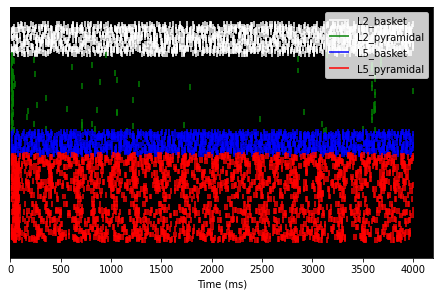

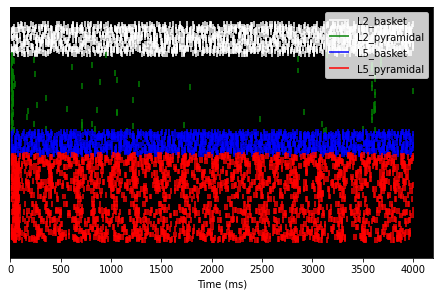

In [7]:
net_train.cell_response.plot_spikes_raster()

In [8]:
#LSTM/GRU architecture for decoding
class model_lstm(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim=64, n_layers=5, dropout=0.1, kernel_size=200, device='cuda:0', bidirectional=False):
        super(model_lstm, self).__init__()

        #multiplier based on bidirectional parameter
        if bidirectional:
            num_directions = 2
        else:
            num_directions = 1

        # Defining some parameters
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers * num_directions
        self.device = device
        self.dropout = dropout
        self.bidirectional = bidirectional
        self.kernel_size = kernel_size

        self.tau1, self.tau2 = 10, 20
        self.kernel = self.get_kernel(torch.arange(0, kernel_size, 1),
                                      tau1=self.tau1, tau2=self.tau2).float().to(self.device).flip(0)

        # LSTM Layer
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, n_layers, batch_first=True, dropout=dropout)   

        self.fc_input = nn.Sequential(
            nn.Linear(input_size, self.hidden_dim),
            nn.Tanh(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.Tanh()
        )

        self.fc_output = nn.Sequential(
            nn.Tanh(),
            nn.Linear(hidden_dim*num_directions, self.hidden_dim),
            nn.Tanh(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.Linear(self.hidden_dim, self.output_size)

        )
    
    def forward(self, x, hidden):
        batch_size = x.size(0)
    
        kernel_product = self.kernel.tile(dims=(batch_size, self.input_size, 1)).transpose(1,2)

        out = (kernel_product * x).sum(dim=1).unsqueeze(1)
        # print(out.shape)

        out = self.fc_input(out.contiguous())
        out, hidden = self.lstm(out, hidden)
        out = out.contiguous()
        out = self.fc_output(out)
            
        return out, hidden
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        weight = next(self.parameters()).data.to(self.device)

        # LSTM cell initialization
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(self.device),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(self.device))
    
        return hidden

    def get_kernel(self, t_vec, tau1=10, tau2=20):
        G = tau2/(tau2-tau1)*(-torch.exp(-t_vec/tau1) + torch.exp(-t_vec/tau2))
        return G

In [9]:
model = model_lstm(input_size=input_size, output_size=output_size, device=device).to(device)


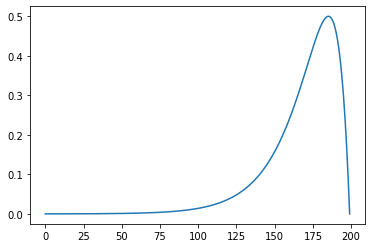

In [10]:
plt.plot(model.kernel.detach().cpu().numpy())

In [11]:
mat = validation_set[:10][0].detach().cpu()
vec = model.kernel.detach().cpu()

In [12]:
def train_validate_model(model, optimizer, criterion, max_epochs, training_generator, validation_generator, device, print_freq=10, early_stop=20):
    kernel_size = model.kernel_size

    train_loss_array = []
    validation_loss_array = []
    # Loop over epochs
    min_validation_loss, min_validation_std, min_validation_counter, min_validation_epoch = np.inf, np.inf, 0, 0
    for epoch in range(max_epochs):
        #___Train model___
        model.train()
        train_batch_loss = []
        validation_batch_loss = []
        for batch_x, batch_y in training_generator:
            optimizer.zero_grad() # Clears existing gradients from previous epoch
            batch_x = batch_x.float().to(device)
            batch_y = batch_y.float().to(device)

            output_sequence = []
            hidden = model.init_hidden(batch_x.size(0))
            for t in range(kernel_size, batch_x.size(1)-1):
                output, hidden = model(batch_x[:,(t-kernel_size):t, :], hidden)
                output_sequence.append(output)

            output_sequence = torch.cat(output_sequence, dim=1)
            train_loss = criterion(output_sequence, batch_y[:,kernel_size+1:,:])

            train_loss.backward() # Does backpropagation and calculates gradients
            optimizer.step() # Updates the weights accordingly

            train_batch_loss.append(train_loss.item())
        
        train_loss_array.append(train_batch_loss)

        #___Evaluate Model___
        with torch.no_grad():
            model.eval()
            #Generate train set predictions
            for batch_x, batch_y in validation_generator:
                batch_x = batch_x.float().to(device)
                batch_y = batch_y.float().to(device)

                output_sequence = []
                hidden = model.init_hidden(batch_x.size(0))
                for t in range(kernel_size, batch_x.size(1)):
                    output, hidden = model(batch_x[:,(t-kernel_size):t, :], hidden)
                    output_sequence.append(output)

                output_sequence = torch.cat(output_sequence, dim=1)
                validation_loss = criterion(output_sequence, batch_y[:,kernel_size:,:])

                validation_batch_loss.append(validation_loss.item())

        validation_loss_array.append(validation_batch_loss)

        #Compute average loss on batch
        train_epoch_loss = np.mean(train_batch_loss)
        train_epoch_std = np.std(train_batch_loss)
        validation_epoch_loss = np.mean(validation_batch_loss)
        validation_epoch_std = np.std(validation_batch_loss)

       #Check if validation loss reaches minimum 
        if validation_epoch_loss < min_validation_loss:
            print('*',end='')
            min_validation_loss = np.copy(validation_epoch_loss)
            min_validation_std = np.copy(validation_epoch_std)
            min_validation_counter = 0
            min_validation_epoch = np.copy(epoch+1)

            min_train_loss = np.copy(train_epoch_loss)
            min_train_std = np.copy(train_epoch_std)
            
        else:
            print('.',end='')
            min_validation_counter += 1

        #Print Loss Scores
        if (epoch+1)%print_freq == 0:
            print('')
            print('Epoch: {}/{} ...'.format(epoch+1, max_epochs), end=' ')
            print('Train Loss: {:.4f}  ... Validation Loss: {:.4f}'.format(train_epoch_loss,validation_epoch_loss))
        
        #Early stop if no validation improvement over set number of epochs
        if min_validation_counter > early_stop:
            print(' Early Stop; Min Epoch: {}'.format(min_validation_epoch))
            break

    loss_dict = {'min_validation_loss':min_validation_loss, 'min_validation_std':min_validation_std,'min_validation_epoch':min_validation_epoch, 
    'min_train_loss':min_train_loss, 'min_train_std':min_train_std,
    'train_loss_array':train_loss_array, 'validation_loss_array':validation_loss_array, 'max_epochs':max_epochs}
    return loss_dict

In [13]:
lr = 1e-3
weight_decay = 1e-4
max_epochs = 1000
criterion = nn.MSELoss()
# criterion = nn.HuberLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)


#Train model
loss_dict = train_validate_model(model, optimizer, criterion, max_epochs, training_generator, validation_generator, device, 10, 10)


*********.
Epoch: 10/1000 ... Train Loss: 0.6217  ... Validation Loss: 0.6483
.*.***....
Epoch: 20/1000 ... Train Loss: 0.5780  ... Validation Loss: 0.5975
*...**....
Epoch: 30/1000 ... Train Loss: 0.5540  ... Validation Loss: 0.5863
.*.****.**
Epoch: 40/1000 ... Train Loss: 0.5211  ... Validation Loss: 0.5444
.**.....*.
Epoch: 50/1000 ... Train Loss: 0.5074  ... Validation Loss: 0.5380
.**..*..**
Epoch: 60/1000 ... Train Loss: 0.4809  ... Validation Loss: 0.5070
......*..*
Epoch: 70/1000 ... Train Loss: 0.4677  ... Validation Loss: 0.4997
.*.....*..
Epoch: 80/1000 ... Train Loss: 0.4510  ... Validation Loss: 0.4984
*.......*.
Epoch: 90/1000 ... Train Loss: 0.4490  ... Validation Loss: 0.5081
..........
Epoch: 100/1000 ... Train Loss: 0.4536  ... Validation Loss: 0.5381
 Early Stop; Min Epoch: 89


In [15]:
torch.save(model.state_dict(), f'{dataset_cell_type}_model.pt')

In [16]:
vsec_names = training_set.vsec_names
isec_names = training_set.isec_names

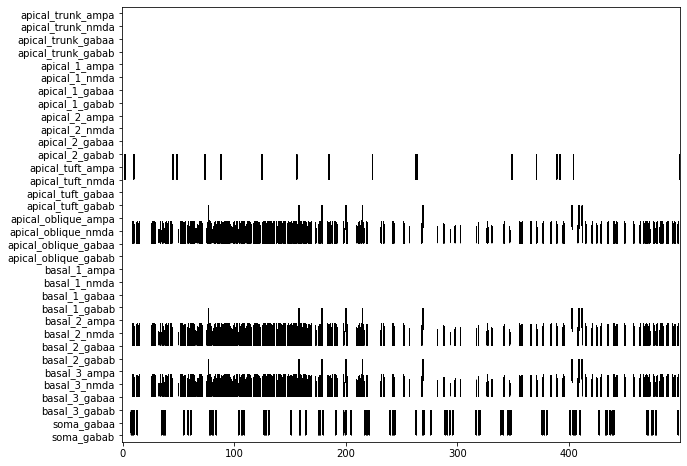

In [17]:
plt.figure(figsize=(10,8))

plt.imshow(validation_set[:][0][0, :, :].detach().cpu().numpy().T, aspect='auto', cmap='gray_r', vmin=0, vmax=0.0001)
_ = plt.yticks(ticks=list(range(len(isec_names))), labels=isec_names)

In [18]:
# test_pred = utils.evaluate_model(model, validation_generator, device)
# test_pred = test_pred.squeeze()

In [19]:
def run_model(model, validation_set):
    val_data = validation_set[:][0][:,:,:].float().to(device)
    with torch.no_grad():
        model.eval()
        output_sequence = []
        hidden = model.init_hidden(val_data.size(0))
        for t in range(model.kernel_size, val_data.size(1)):
            output, hidden = model(val_data[:,(t-model.kernel_size):t, :], hidden)
            output_sequence.append(output)

        output_sequence = torch.cat(output_sequence, dim=1)

    return output_sequence


In [27]:
test_pred = run_model(model, validation_set)


In [21]:
val_plot_data = np.concatenate(validation_set[:][1][:,model.kernel_size:,:].detach().cpu().numpy(), axis=0)
test_plot_data = np.concatenate(test_pred.detach().cpu().numpy(), axis=0)

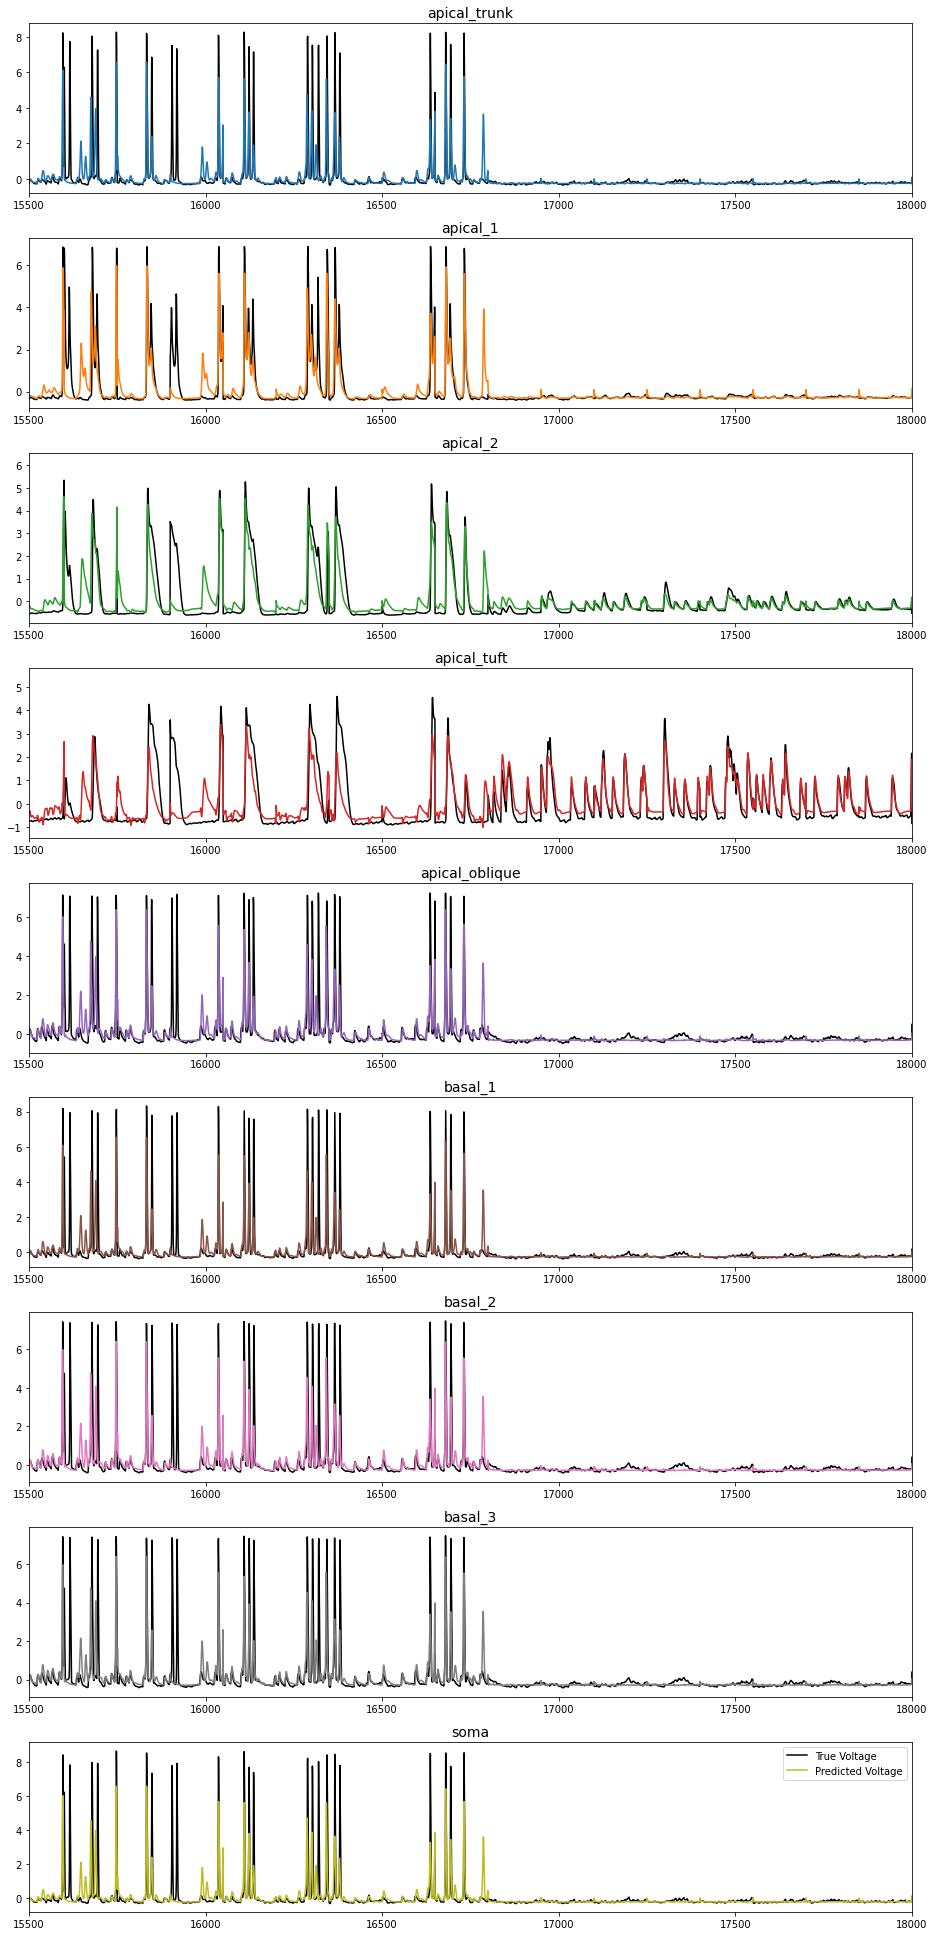

In [26]:

plt.figure(figsize=(13,3 * output_size))
tvec = np.linspace(0, val_plot_data.shape[0] * dt, val_plot_data.shape[0])
for idx in range(output_size):
    plt.subplot(output_size, 1, idx+1)
    plt.plot(tvec, val_plot_data[:,idx], color='k', label='True Voltage')
    # plt.plot(test_pred, color=f'C{idx}', label='Predicted Voltage')
    plt.plot(tvec, test_plot_data[:,idx], color=f'C{idx}', label='Predicted Voltage')
    plt.xlim(31000/2,36000/2)
    plt.title(vsec_names[idx], fontsize=14)
    # plt.ylim(-0.5,1.8)
plt.legend()
plt.tight_layout()

In [71]:
np.concatenate(test_pred, axis=0).shape

(14436, 9)